# KoSimCSE training (Supervised)
---

In [3]:
import json
import os
import random
import argparse
# from dataclasses import dataclass
# from pathlib import Path
from typing import Dict, List, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from more_itertools import chunked
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer, logging
from transformers.modeling_outputs import BaseModelOutputWithPoolingAndCrossAttentions
from transformers.modeling_utils import PreTrainedModel
from transformers.optimization import get_linear_schedule_with_warmup
from transformers.tokenization_utils import BatchEncoding, PreTrainedTokenizer

from src.sts import STSEvaluation
from src.simcse import SimCSEModel, set_seed

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def parse_args():
    """Parse the arguments."""
    parser = argparse.ArgumentParser()

    # path
    parser.add_argument("--base_model", type=str, default="klue/roberta-base", help="Model id to use for training.")
    parser.add_argument("--dataset_dir", type=str, default="dataset-sup-train")
    parser.add_argument("--output_dir", type=str, default="./sup-model")
    
    # add training hyperparameters
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size to use for training.")
    # the number of epochs is 1 for Unsup-SimCSE, and 3 for Sup-SimCSE in the paper
    parser.add_argument("--num_epochs", type=int, default=1)
    parser.add_argument("--lr", type=float, default=3e-5, help="Learning rate to use for training.")
    parser.add_argument("--num_warmup_steps", type=int, default=0)
    parser.add_argument("--temperature", type=float, default=0.05) # see Table D.1 of the paper
    parser.add_argument("--lr_scheduler_type", type=str, default="linear")

    parser.add_argument("--max_seq_len", type=int, default=32)
    parser.add_argument("--eval_steps", type=int, default=50)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--device", type=str, default="cuda:0")
    parser.add_argument("--debug", default=True, action="store_true")

    args = parser.parse_known_args()
    return args

In [4]:
args, _ = parse_args()
args.base_model = "klue/roberta-base"

In [5]:
logging.set_verbosity_error()
set_seed(args.seed)
os.makedirs(args.output_dir, exist_ok=True)

from datasets import load_from_disk
train_dataset = load_from_disk(args.dataset_dir)

if args.debug:
    train_num_samples = 20000
    train_dataset = train_dataset.shuffle(seed=42).select(range(train_num_samples))

tokenizer = AutoTokenizer.from_pretrained(args.base_model)
model = SimCSEModel(args.base_model).to(args.device)

In [6]:
from transformers import default_data_collator

train_dataloader = DataLoader(
    train_dataset,
    collate_fn=default_data_collator,
    batch_size=args.batch_size,
    shuffle=True,
    # num_workers and pin_memory are for speeding up training
    num_workers=4,
    pin_memory=True,
    # batch_size varies in the last batch because
    # the last batch size will be the number of remaining samples (i.e. len(train_dataloader) % batch_size)
    # to avoid unstablity of contrastive learning, we drop the last batch
    drop_last=True,
)

In [7]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=args.lr)

# reference implementation uses a linear scheduler with warmup, which is a default scheduler of transformers' Trainer
# with num_training_steps = 0 (i.e. no warmup)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=args.num_warmup_steps,
    # len(train_dataloader) is the number of steps in one epoch
    num_training_steps=len(train_dataloader) * args.num_epochs,
)

In [8]:
sts = STSEvaluation()

@torch.inference_mode()
def encode(texts: List[str]) -> torch.Tensor:
    embs = []
    model.eval()
    for text in chunked(texts, args.batch_size * 8):
        batch: BatchEncoding = tokenizer(
            text,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )
        # SimCSE uses MLP layer only during training
        # in this implementation, we use `model.training` to switch between training and evaluation
        emb = model(**batch.to(args.device))
        embs.append(emb.cpu())
    # shape of output: (len(texts), hidden_size)
    return torch.cat(embs, dim=0)

# evaluation before training
model.eval()
best_sts = sts.dev(encode=encode)["avg"]
best_step = 0

# evaluate the model and store metrics before training
# this is important to check the appropriateness of training procedure
print(f"epoch: {0:>3};\tstep: {0:>6};\tloss: {' '*9}nan;\tAvg. STS: {best_sts:.5f};")
logs: List[Dict[str, Union[int, float]]] = [
    {
        "epoch": 0,
        "step": best_step,
        "loss": None,
        "sts": best_sts,
    }
]

for epoch in range(args.num_epochs):
    model.train()

    # tqdm makes it easy to visualize how well the training is progressing
    for step, batch in tqdm(
        enumerate(train_dataloader),
        total=len(train_dataloader),
        dynamic_ncols=True,
    ):
        # transfer batch to the device
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        token_type_ids = batch['token_type_ids']

        z1_input_ids = input_ids[:, 0, :].to(args.device)
        z2_input_ids = input_ids[:, 1, :].to(args.device)
        z3_input_ids = input_ids[:, 2, :].to(args.device)
        z1_attention_mask = attention_mask[:, 0, :].to(args.device)
        z2_attention_mask = attention_mask[:, 1, :].to(args.device)
        z3_attention_mask = attention_mask[:, 2, :].to(args.device)
        z1_token_type_ids = token_type_ids[:, 0, :].to(args.device)
        z2_token_type_ids = token_type_ids[:, 1, :].to(args.device)
        z3_token_type_ids = token_type_ids[:, 2, :].to(args.device)

        # embedding
        z1_emb = model.forward(input_ids=z1_input_ids, attention_mask=z1_attention_mask, token_type_ids=z1_token_type_ids)
        z2_emb = model.forward(input_ids=z2_input_ids, attention_mask=z2_attention_mask, token_type_ids=z2_token_type_ids)
        z3_emb = model.forward(input_ids=z3_input_ids, attention_mask=z3_attention_mask, token_type_ids=z3_token_type_ids)

        # SimCSE training objective:
        #    maximize the similarity between the same sentence
        # => make diagonal elements most similar        
        # FYI: SimCSE is sensitive for the temperature parameter.
        # see Table D.1 of the paper        
        z1_z2_sim = F.cosine_similarity(z1_emb.unsqueeze(1), z2_emb.unsqueeze(0), dim=-1) / args.temperature
        z1_z3_sim = F.cosine_similarity(z1_emb.unsqueeze(1), z3_emb.unsqueeze(0), dim=-1) / args.temperature
        sim_matrix = torch.cat([z1_z2_sim, z1_z3_sim], dim=1)

        # labels := [0, 1, 2, ..., batch_size - 1]
        # labels indicate the index of the diagonal element (i.e. positive examples)
        labels = torch.arange(args.batch_size).long().to(args.device)
        # it may seem strange to use Cross-Entropy Loss here.
        # this is a shorthund of doing SoftMax and maximizing the similarity of diagonal elements
        loss = F.cross_entropy(sim_matrix, labels)

        loss.backward()
        optimizer.step()

        lr_scheduler.step()
        optimizer.zero_grad()

        # for every `args.eval_steps` steps, perform evaluation on STS task and print logs
        if (step + 1) % args.eval_steps == 0 or (step + 1) == len(train_dataloader):
            model.eval()
            # evaluate on the STS-B development set
            sts_score = sts.dev(encode=encode)["avg"]

            # you should use the best model for the evaluation to avoid using overfitted model
            # FYI: https://github.com/princeton-nlp/SimCSE/issues/62
            if best_sts < sts_score:
                best_sts = sts_score
                best_step = step + 1
                # only save the best performing model
                torch.save(model.state_dict(), f"{args.output_dir}/model.pt")

            # use `tqdm.write` instead of `print` to prevent terminal display corruption
            tqdm.write(
                f"epoch: {epoch:>3};\tstep: {step+1:>6};\tloss: {loss.item():.10f};\tAvg. STS: {sts_score:.5f};"
            )
            logs.append(
                {
                    "epoch": epoch,
                    "step": step + 1,
                    "loss": loss.item(),
                    "sts": sts_score,
                }
            )
            pd.DataFrame(logs).to_csv(f"{args.output_dir}/logs.csv", index=False)

            # if you want to see the changes of similarity matrix, uncomment the following line
            # tqdm.write(str(sim_matrix))
            model.train()

epoch:   0;	step:      0;	loss:          nan;	Avg. STS: 21.02447;


 16%|█▌        | 50/312 [00:29<05:27,  1.25s/it]

epoch:   0;	step:     50;	loss: 1.1565836668;	Avg. STS: 78.62807;


 32%|███▏      | 100/312 [00:55<04:01,  1.14s/it]

epoch:   0;	step:    100;	loss: 0.9469836354;	Avg. STS: 80.77088;


 48%|████▊     | 150/312 [01:21<03:13,  1.19s/it]

epoch:   0;	step:    150;	loss: 1.1948935986;	Avg. STS: 81.44424;


 64%|██████▍   | 200/312 [01:47<02:10,  1.16s/it]

epoch:   0;	step:    200;	loss: 0.6844779253;	Avg. STS: 81.73668;


 80%|████████  | 250/312 [02:13<01:11,  1.15s/it]

epoch:   0;	step:    250;	loss: 1.0459398031;	Avg. STS: 82.66290;


 96%|█████████▌| 300/312 [02:40<00:14,  1.19s/it]

epoch:   0;	step:    300;	loss: 1.0793266296;	Avg. STS: 82.72849;


100%|██████████| 312/312 [02:48<00:00,  1.17s/it]

epoch:   0;	step:    312;	loss: 0.9630827904;	Avg. STS: 82.74144;


100%|██████████| 312/312 [02:48<00:00,  1.85it/s]


In [9]:
# save num_epochs, steps, losses, and STS dev scores
with open(f"{args.output_dir}/dev-metrics.json", "w") as f:
    data = {
        "best-step": best_step,
        "best-sts": best_sts,
    }
    json.dump(data, f, indent=2, ensure_ascii=False)

with open(f"{args.output_dir}/config.json", "w") as f:
    data = {k: v if type(v) in [int, float] else str(v) for k, v in vars(args).items()}

[Text(0.5, 1.0, 'Avg. STS')]

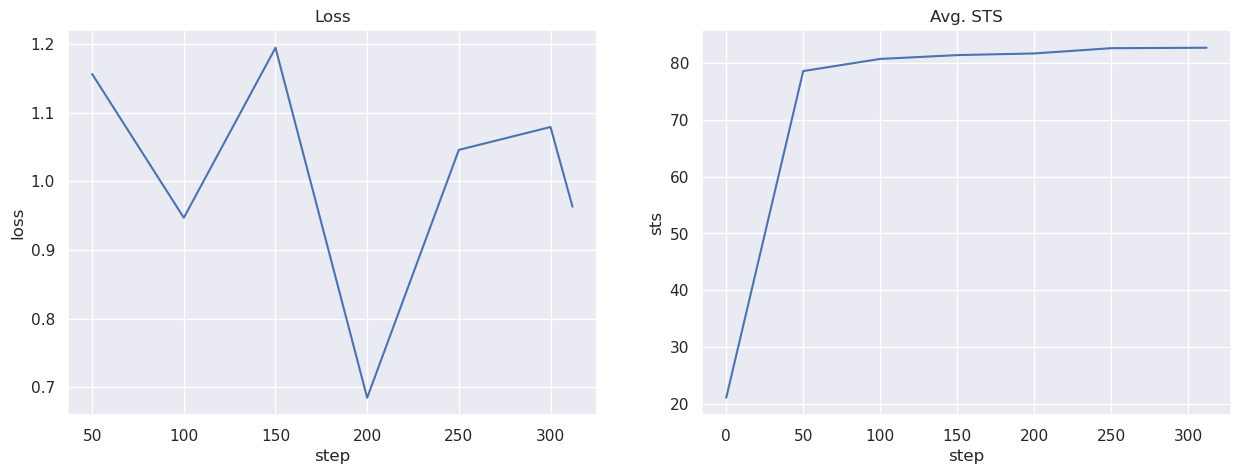

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

log = pd.read_csv(f"{args.output_dir}/logs.csv")

sns.set(rc={'figure.figsize':(15, 5)})
fig, axes = plt.subplots(ncols=2)
sns.lineplot(data=log, x="step", y="loss", ax=axes[0]).set(title="Loss")
sns.lineplot(data=log, x="step", y="sts", ax=axes[1]).set(title="Avg. STS")

In [13]:
from src.infer import show_embedding_score

model = model.eval().cpu()
sentences = ['이번 주 일요일에 분당 이마트 점은 문을 여나요?',
             '일요일에 분당 이마트는 문 열어요?',
             '분당 이마트 점은 토요일에 몇 시까지 하나요']
show_embedding_score(tokenizer, model, sentences)

tensor([[97.6252]], grad_fn=<MulBackward0>) tensor([[89.3523]], grad_fn=<MulBackward0>)
